# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

## Merged models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from datetime import datetime, date
from dateutil.parser import parse
from dotenv import load_dotenv

from NLP_tools import *

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import *
from opensearchpy import helpers

from openai import OpenAI

### Inicializamos la base vectorial

In [4]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Path

In [5]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [6]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Cargamos noticias 
- Notas:
    - Se carga el segundo batch de noticias, luego de haber corrido al menos el primero y segundo batch con la notebook NLP_01_data
    - Se debe haber generado el primer modelo en NLP_02_model
    - Para cargar el segundo batch, se utiliza la fecha como identificador del lote

In [7]:
# Cargar batch de noticias ( a partir del segundo batch en adelante ) por fecha previamente preprocesado en NLP_01_data 
choice = "20240717"  
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]
batch_news = get_news(date_choice)

if batch_news == []:
    print("No hay noticias a procesar")

id_data     = [reg[0] for reg in batch_news]
title_data  = [reg[1] for reg in batch_news]
news_data   = [reg[2] for reg in batch_news]
keywords    = [reg[3] for reg in batch_news]
entities    = [reg[4] for reg in batch_news]
created     = [reg[5] for reg in batch_news]

# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

6146

### Preprocesar batch de noticias

In [8]:
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(news_data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)

100%|██████████| 1000/1000 [00:01<00:00, 588.53it/s]


### Modelo para el batch

In [9]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(news_data)

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model_2 = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Entrenamiento

In [10]:
# Entrenamiento
_, _ = topic_model_2.fit_transform(proc_data)

# No necesito generar topicos, ni probabilidades, ni embeddings del modelo 2, ya que vamos a fusionar modelos.

2024-08-29 18:40:23,029 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-29 18:44:51,302 - BERTopic - Embedding - Completed ✓
2024-08-29 18:44:51,304 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-29 18:45:28,805 - BERTopic - Dimensionality - Completed ✓
2024-08-29 18:45:28,809 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-29 18:45:28,928 - BERTopic - Cluster - Completed ✓
2024-08-29 18:45:28,948 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-29 18:45:30,740 - BERTopic - Representation - Completed ✓


### Merge de modelos

In [11]:
# Cargamos el modelo anterior
topic_model_1 = BERTopic.load(PATH+"modelos_notebook/bertopic_model_last")
print(f"Topicos anteriores: {len(set(topic_model_1.get_topics().keys()))-1}")

Topicos anteriores: 20


In [12]:
# Combinar los modelos en uno solo
merged_model = BERTopic.merge_models([topic_model_1, topic_model_2])

In [13]:
# Grabar modelo fusionado
merged_model.save(PATH+f"modelos_notebook/bertopic_model_last")

2024-08-29 18:47:33,917 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [14]:
print(f"Cantidad de tópicos modelo 1: {len(topic_model_1.get_topic_info())} -- del 0 al {len(topic_model_1.get_topic_info())-1} (incluye topico -1)")
print(f"Cantidad de tópicos modelo 2: {len(topic_model_2.get_topic_info())} -- del 0 al {len(topic_model_2.get_topic_info())-1} (incluye topico -1)")
print(f"Cantidad de tópicos modelo merge: {len(merged_model.get_topic_info())} -- del 0 al {len(merged_model.get_topic_info())-1} (incluye topico -1)")

Cantidad de tópicos modelo 1: 21 -- del 0 al 20 (incluye topico -1)
Cantidad de tópicos modelo 2: 23 -- del 0 al 22 (incluye topico -1)
Cantidad de tópicos modelo merge: 26 -- del 0 al 25 (incluye topico -1)


In [15]:
# Armar set de datos para inferir (ya procesados y nuevos)
news_data_1 = get_news( process=True )
df_news_1 = pd.DataFrame(news_data_1 , columns=["indice", "titulo", "noticia", "keywords", "entidades", "creado", "pos_id"])
df_news_1.sort_values("pos_id", ascending=True, inplace=True)

news_data_2 = {"indice":id_data, "titulo":title_data, "noticia":news_data, "keywords":keywords, "entidades":entities, "creado":created}
df_news_2 = pd.DataFrame(news_data_2)

df_unificado = pd.concat([df_news_1, df_news_2], ignore_index=True)

In [16]:
# Listas de atributos de datos unificados
u_id_data      = list(df_unificado['indice'])
u_title_data   = list(df_unificado['titulo'])
u_data         = list(df_unificado['noticia'])

In [17]:
# Topicos validos (quitamos el topico -1)
topics_to_save = list(merged_model.get_topics().keys())[1:]
len(topics_to_save)

25

In [18]:
# Visualizar cantidad de documentos que aportan a los topicos el modelo anterior, el modelo fusionado, y el total de ambos
df_combined = merged_results(topic_model_1, merged_model)
print(df_combined)

    Topic  Count1  Count2  Merged
0      -1   335.0   301.0     636
1       0   156.0    85.0     241
2       1    91.0    92.0     183
3       2    70.0    45.0     115
4       3    49.0    59.0     108
5       4    32.0    16.0      48
6       5    27.0    13.0      40
7       6    25.0   171.0     196
8       7    24.0     0.0      24
9       8    23.0     0.0      23
10      9    21.0    26.0      47
11     10    18.0     0.0      18
12     11    18.0     0.0      18
13     12    18.0    27.0      45
14     13    18.0     0.0      18
15     14    13.0    58.0      71
16     15    13.0     0.0      13
17     16    13.0    16.0      29
18     17    12.0     0.0      12
19     18    12.0     0.0      12
20     19    12.0     0.0      12
21     20     NaN    30.0      30
22     21     NaN    20.0      20
23     22     NaN    19.0      19
24     23     NaN    12.0      12
25     24     NaN    10.0      10


In [19]:
# Topicos modelo merged
merged_model.topic_labels_

{-1: '-1_argentina_sociedades_2024_país',
 0: '0_víctima_penal_policía_años',
 1: '1_viviendas_pacto_ley_reunión',
 2: '2_actividades_cultura_turismo_comunidad',
 3: '3_cuotas_categoría_multas_contribuyentes',
 4: '4_show_cantante_fanáticos_entretiempo',
 5: '5_incendio_bomberos_incendios_fuego',
 6: '6_refuerzos_club_jugadores_futbolistas',
 7: '7_dólar_compra_brecha_dólares',
 8: '8_demencia_azúcar_salud_preeclampsia',
 9: '9_temperatura_precipitaciones_temperaturas_lluvias',
 10: '10_inteligencia_agencia_agencias_inteligencia nacional',
 11: '11_soles_empleo_em_capacidad instalada',
 12: '12_periodistas_periodista_presidente_medios',
 13: '13_millones_bancos_liquidez_banco central',
 14: '14_crecimiento_inflación_alza_repunte',
 15: '15_jugador_español_ciudad deportiva_em',
 16: '16_lesión_tobillo_selección_copas',
 17: '17_juego_rompecabezas_batalla_drones',
 18: '18_participantes_isla_inmunidad_reality',
 19: '19_hs_música_piano_orquesta',
 20: '6_netflix_temporada_reality_persona

In [20]:
# Elegir un topico que tenga aporte de noticias al topico por ambos modelos
topic_id = 0
docs_per_topics = [i for i, x in enumerate(merged_model.topics_) if x == topic_id]


print(f"Noticias totales del topico {topic_id}:", len(docs_per_topics))
# Lista de columnas que quieres excluir
columnas_a_excluir = ['noticia', 'keywords','entidades','pos_id']


df_query = df_unificado.loc[docs_per_topics, df_unificado.columns.difference(columnas_a_excluir)]
df_query.style.set_properties(subset=['titulo'], **{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('min-width', '50px')]}, {'selector': 'td', 'props': [('min-width', '140px')]}])

Noticias totales del topico 0: 241


,creado,indice,titulo
0,2024-07-16T09:52:55,114831253,Burlando ofreció una recompensa para encontrar a Loan
5,2024-07-16T15:10:25,114862220,El régimen de Nicaragua excarceló a otros 1.500 presos comunes por el aniversario de la revolución sandinista
11,2024-07-16T07:21:20,114822997,"Con un asesino en su celda y los cuatro federales que defendía en el pabellón, así pasa sus días en la cárcel el abogado acusado de Trata"
29,2024-07-16T07:55:42,114824171,"TikTok permite acceder a adolescentes a su tienda aunque está prohibida para menores de 18 años, según TechCrunch"
32,2024-07-16T18:23:01,114881002,Polémica en Italia: video muestra a un hombre que sacó a latigazos a mujeres inmigrantes de un camión
37,2024-07-16T13:11:23,114845193,"Fernando Burlando anticipó que la declaración de Laudelina ""va a subir más el tono del escándalo"""
42,2024-07-16T03:21:55,114813148,Alumno develó ante una psicóloga que fue abusado hace ocho años
43,2024-07-16T19:10:35,114878575,Primera sentencia tras la reforma de la Justicia federal en Santa Fe: dos condenados por enviar droga en encomiendas
44,2024-07-16T02:03:51,114806333,Balearon a un hombre en zona norte: fue internado con tres heridas en la cabeza
46,2024-07-16T11:20:39,114837084,Citaron a indagatoria a los 7 imputados por el caso Loan


### Obtenemos transformaciones y embeddings del batch

In [21]:
topics_batch, probs_batch = merged_model.transform(news_data)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-29 18:57:20,476 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [22]:
# Obtenemos embeddings de todos los documentos
docs_embedding_batch = merged_model.embedding_model.embed(news_data)

### Actualizar datos en news 

In [23]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, probs 
update_news( id_data, docs_embedding_batch, topics_batch, probs_batch )

True

### Actualizar en Topicos

In [24]:
# Obtener las fechas desde/hasta de los topicos existentes de opensearch
from_date, to_date = get_topics_date()
from_date, to_date

(['2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00'],
 ['2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00']

In [25]:
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

# Preparar fechas para actualizar en los topicos ( excluyendo topico -1)
from_date_to_save, to_date_to_save = update_topics_date(from_date, to_date, df_combined[1:], date_choice)
from_date_to_save, to_date_to_save

(['2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00'],
 ['2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-18T00:00:00',

In [26]:
# Topicos validos (quitamos el topico -1)
topics_to_save = list(merged_model.get_topics().keys())[1:]

In [27]:
# Obtener los nombres de los tópicos existentes
topics_name = get_topics_opensearch()
topics_name = [name['name'] for name in topics_name]
topics_name


['Violencia y justicia en la sociedad',
 'Diálogo entre Gobierno y CGT',
 'Actividades culturales y recreativas invernales',
 'Cambios en regulaciones y tarifas',
 'Accidentes y polémicas en espectáculos',
 'Incendios forestales en Córdoba',
 'Escándalo por refuerzos de Boca',
 'Cotización del dólar blue hoy',
 'Consejos de cocina y salud.',
 'Pronóstico del clima en Argentina',
 'Disolución y reestructuración de inteligencia.',
 'Crisis económica en América Latina',
 'Relaciones políticas y seguridad presidencial',
 'Riesgos económicos en Argentina',
 'Pronóstico de recesión en Argentina',
 'Presentación de Kylian Mbappé',
 'Recepción de la Selección Argentina',
 'Temas diversos de actualidad.',
 'Reality show de supervivencia extrema',
 'Actividades culturales y eventos destacados']

In [28]:
# Eliminar topicos existentes
delete_index_opensearch("topic")

# Grabar todos los topicos en la base
for topic_id in merged_model.get_topics().keys():
    
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, merged_model, PATH)
        topic_entities_top  = get_top_entities_os(topic_id)
        topic_documents_title, threshold  = get_top_documents_threshold(topic_id)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, merged_model, docs_embedding_batch, u_id_data, u_title_data, u_data)
        
        topic_doc = Topic(
            index = topic_id,
            name = get_topic_name(''.join(topic_documents_title), topic_id, merged_model, client),
            vector = list(merged_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = parse(from_date[topic_id]),
            from_date = parse(from_date[topic_id]),
            to_date = parse(to_date[topic_id]),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()


Nota: Cada modelo puede representar ordenes distintos de los topicos, pero al fusionarlos, el orden del modelo 1 se mantiene en el fusionado y se agregan los nuevos al final

### Verificacion

#### Temporalidad de los topicos

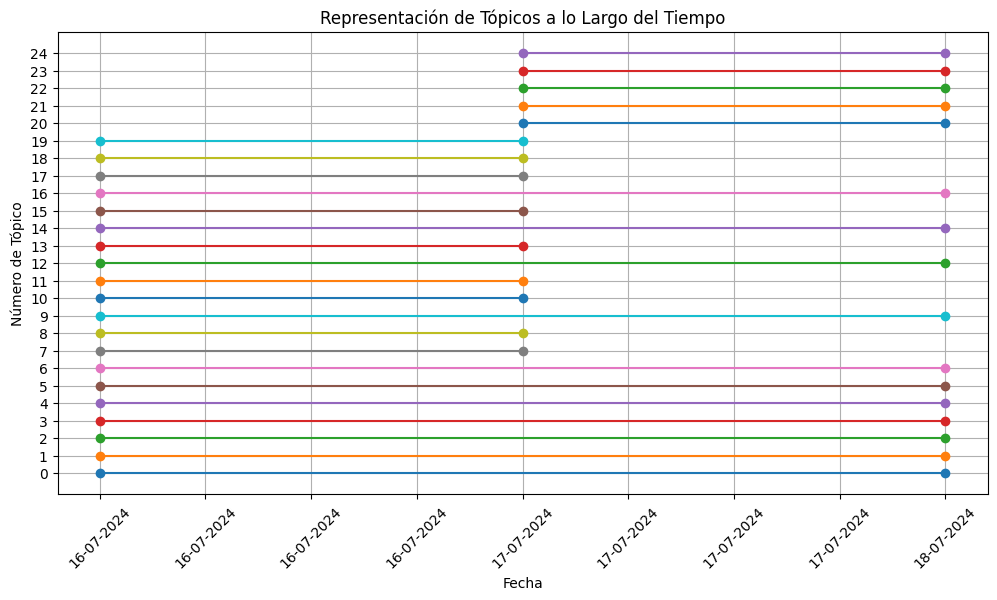

In [29]:
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt
import pandas as pd

data_plot = {'topic': range(len(merged_model.get_topics().keys())-1),
             'from': from_date_to_save,
             'to': to_date_to_save}

df_plot = pd.DataFrame(data_plot)
df_plot['from'] = pd.to_datetime(df_plot['from'], format='ISO8601')
df_plot['to'] = pd.to_datetime(df_plot['to'], format='ISO8601')

plt.figure(figsize=(12, 6))

for index, row in df_plot.iterrows():
    plt.plot([row['from'], row['to']], [row['topic'], row['topic']], marker='o')

# Formatear las fechas en el eje X
date_form = DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_form)

# Ajustar los ticks del eje X para que no se repitan las fechas
locator = AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.yticks(df_plot['topic'].unique())
plt.xlabel('Fecha')
plt.ylabel('Número de Tópico')
plt.title('Representación de Tópicos a lo Largo del Tiempo')
plt.grid(True)

# Rotar las etiquetas de fecha para mejor legibilidad (opcional)
plt.xticks(rotation=45)

plt.show()


### Panel de Topicos

In [30]:
def panel_topicos(fecha):
    df_topics = pd.DataFrame(get_topics_opensearch(fecha))

    if not df_topics.empty:

        columnas_a_excluir = ['vector', 'created_at', 'best_doc']

        df_query = df_topics[df_topics.columns.difference(columnas_a_excluir)].sort_values("index", ascending=True)
        column_order = ['index','name','from_date', 'to_date', 'similarity_threshold', 'keywords', 'entities', 'id_best_doc', 'title_best_doc']

        df_result = df_query.reindex(columns=column_order).style.set_properties(subset=['name'], **{'text-align': 'left'}).set_table_styles([{'selector': 'th','props': [('min-width', '40px')]},
                                                                                                                                             {'selector': 'td', 'props': [('min-width', '140px')]}])
        
        return df_result
    else:
        print("No hay tópicos para los parámetros elegidos")


In [43]:
# la fecha de consulta se relaciona con la vigencia, es decir con "to_date"
fecha = None
fecha = "2024-07-18"
panel_topicos(fecha)

,index,name,from_date,to_date,similarity_threshold,keywords,entities,id_best_doc,title_best_doc
1,0,Casos de violencia y justicia,2024-07-16T00:00:00,2024-07-18T00:00:00,0.581793,"{'víctima': 0.037104171978807346, 'penal': 0.030263726839680868, 'policía': 0.03018171132952901, 'años': 0.02909480773526311, 'robo': 0.02815884830305443}","{'Loan Danilo Peña': 28, 'Laudelina Peña': 23, 'Fiscalía': 17, 'Fernando Burlando': 13, 'Loan': 13, 'Walter Maciel': 13, 'Diego Pellegrini': 12, 'Argentina': 11, 'María Victoria Caillava': 10, 'Néstor Luque': 10}",114853477,"Juan Román Riquelme explicó por qué Boca no llegó a inscribir a sus refuerzos para la Sudamericana: ""La Conmebol fue muy estricta"""
9,1,Reuniones entre Gobierno y CGT,2024-07-16T00:00:00,2024-07-18T00:00:00,0.537703,"{'viviendas': 0.03110535323390696, 'pacto': 0.031072229762581425, 'ley': 0.030939093564710085, 'reunión': 0.02809551888636326}","{'Gobierno': 31, 'Javier Milei': 27, 'Axel Kicillof': 16, 'Consejo de Mayo': 16, 'Congreso': 15, 'Gobierno nacional': 15, 'Provincia': 15, 'CGT': 13, 'PRO': 13, 'Río Negro': 12}",114819866,El ministro Javier Rodríguez encabezó la Mesa Provincial de Desarrollo Apícola
10,2,Actividades culturales y recreativas invernales,2024-07-16T00:00:00,2024-07-18T00:00:00,0.706653,"{'actividades': 0.047742077579209556, 'cultura': 0.04169427316007076, 'turismo': 0.03470424744007614}","{'Buenos Aires': 8, 'Francia': 6, 'Argentina': 5, 'España': 5, 'Provincia': 5, 'Comodoro Rivadavia': 4, 'Corrientes': 4, 'Córdoba': 4, 'Estados Unidos': 4, 'la Argentina': 4}",114865237,Kicillof inauguró un puente en el Río Reconquista
13,3,Actualizaciones y cambios gubernamentales.,2024-07-16T00:00:00,2024-07-18T00:00:00,0.569975,"{'cuotas': 0.06466674264564469, 'categoría': 0.03950016473663445, 'multas': 0.039286846937594155}","{'AFIP': 13, 'DÓLAR': 10, 'Gobierno': 8, 'Argentina': 5, 'Buenos Aires': 5, 'Provincia': 5, 'la Ley': 5, 'ANSES': 4, 'CBU': 4, 'Ganancias': 4}",114813148,Alumno develó ante una psicóloga que fue abusado hace ocho años
14,4,Accidente de L-Gante en Paraguay,2024-07-16T00:00:00,2024-07-18T00:00:00,0.685599,"{'show': 0.08701216557680137, 'cantante': 0.07729265554938765, 'fanáticos': 0.062289120639853805}","{'Argentina': 12, 'Enzo Fernández': 8, 'Colombia': 6, 'Shakira': 6, 'Chelsea': 5, 'Gracias Paraguay': 5, 'Julio Garro': 4, 'Lionel Messi': 4, 'Alejandro Fantino': 3, 'América': 3}",114879627,El Gobierno logró superávit financiero en junio
12,5,Incendios forestales en Córdoba,2024-07-16T00:00:00,2024-07-18T00:00:00,0.573261,"{'incendio': 0.15232485270745813, 'bomberos': 0.13057001804131127, 'incendios': 0.08943316589819165, 'fuego': 0.08841488963786526}","{'Traslasierra': 11, 'Roberto Schreiner': 9, 'valle de Calamuchita': 8, 'San Javier': 6, 'Villa Berna': 6, 'Villa Dolores': 6, 'Villa General Belgrano': 6, 'Villa del Dique': 6, 'cerro Champaquí': 6, 'provincia de Córdoba': 6}",114845656,París 2024: Lo que hay que saber de la lucha
15,6,Problemas de inscripción en Boca,2024-07-16T00:00:00,2024-07-18T00:00:00,0.736020,"{'refuerzos': 0.08767569570469641, 'club': 0.08029852843738614, 'jugadores': 0.07249894918479795}","{'Boca Juniors': 16, 'Independiente del Valle': 13, 'Boca': 11, 'Brian Aguirre': 8, 'Diego Martínez': 8, 'Milton Giménez': 8, 'Gary Medel': 7, 'Lautaro Blanco': 7, 'Milton Delgado': 7, 'Tomas Belmonte': 7}",114813256,Qué pasa cuando nos miramos al espejo y no nos gusta lo que vemos
11,9,Pronóstico del clima y temperaturas,2024-07-16T00:00:00,2024-07-18T00:00:00,0.438581,"{'temperatura': 0.11676956750487792, 'precipitaciones': 0.11193520700474281, 'temperaturas': 0.10999532886695262, 'lluvias': 0.07259342658942552}","{'Buenos Aires': 6, 'SMN': 5, 'Brasil': 4, 'Pronóstico': 4, 'Julio': 3, 'Pacífico Ecuatorial': 3, 'Río Negro': 3, 'la Argentina': 3, 'Anticiclón Santa Elena': 2, 'El Niño': 2}",114850808,Mirá el papelón histórico que hizo Boca ante la CONMEBOL
3,12,Tensiones políticas y atentados recientes,2024-07-16T00:00:00,2024-07-18T0

### Panel de noticias por topico ( filtrado por umbral del topico y fecha )

In [36]:
def panel_news(topic_id, fecha):

    news_results = select_data_from_news(topic=topic_id)
    if news_results:
        if fecha in news_results[4]:
            data_view = {   'ID': news_results[0],
                            'titulo': news_results[1],
                            'estimacion': news_results[3]}
            
            name, threshold = get_one_topic(topic_id)
            print(f"Noticias del topico {topic_id}: <<< {name} >>> | umbral: {threshold}")
            df_view = pd.DataFrame(data_view)
            df_view.sort_values('estimacion', ascending=False, inplace=True)
            df_result = df_view[df_view['estimacion'] > threshold]

            return df_result
        else:
            print("No hay tópicos para los parámetros elegidos")
    else:
        print("No hay tópicos para los parámetros elegidos")

In [40]:
fecha = None
fecha = '2024-07-16'
topic_id = 8
panel_news(topic_id, fecha)


Noticias del topico 8: <<< Salud y bienestar en la vida cotidiana >>> | umbral: 0.46527642011642456


,ID,titulo,estimacion
0,114870501,Un análisis de sangre se muestra prometedor para detectar la preeclampsia antes de que aparezcan los síntomas,1.000000
8,114857544,Probá este truco de las abuelas para limpiar tu sartén de teflón sin dañarla y que dure mucho más,1.000000
16,114847886,El licuado mágico que ayuda a la salud y combate la obesidad,1.000000
14,114882539,Cuidar el intestino: consejos para mantenerlo saludable y prevenir enfermedades,1.000000
1,114835285,Los mejores 5 guisos para hacer en invierno: las recetas más fáciles de preparar,1.000000
9,114837645,Azúcar en sangre: hay un síntoma que se manifiesta en los ojos y es fácil de detectar,1.000000
26,114836898,"El alimento que prolonga la vida y mejora la salud del cerebro, según Harvard",1.000000
6,114796932,Novedoso: el truco casero para aprovechar los huesos de pollo,1.000000
4,114864492,"Si compraste zanahorias en oferta y se pusieron blandas, no las tires: mirá cómo recuperarlas en un solo paso",1.000000
30,114882162,"Con 6 ingredientes prepará estas barritas de cereal, tan ricas como las del kiosco y más rendidoras",1.000000
